# Training resnet model



In [1]:
#allow for auto reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# all the main external libs used
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *


/home/youngroz/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/youngroz/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/youngroz/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
PATH = "/path/to/data"
sz=64
arch=resnet34
bs=4

In [21]:
# get and move files for valid set 
demFiles = [f for f in os.listdir(PATH+'/train/dems/')]
repFiles = [f for f in os.listdir(PATH+'/train/reps/')]
randomDemFilesVal = np.random.choice(demFiles, int(len(demFiles)*.2), replace=False)
randomRepFilesVal = np.random.choice(repFiles, int(len(demFiles)*.2), replace=False)
print(len(randomDemFilesVal))

for f in randomDemFilesVal: 
    if not os.path.exists(PATH+"/valid/dems"):
            os.makedirs(PATH+"/valid/dems")
    os.rename(PATH +"/train/dems/"+f, PATH+"/valid/dems/"+f)

for f in randomRepFilesVal: 
    if not os.path.exists(PATH+"/valid/reps"):
        os.makedirs(PATH+"/valid/dems")
    os.rename(PATH +"/train/reps/"+f, PATH+"/valid/reps/"+f)

108


In [4]:
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.enabled

True

In [6]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [7]:
lrf=learn.lr_find(start_lr=0.00001)

  7%|▋         | 1/14 [00:04<01:02,  4.81s/it, loss=1.06]


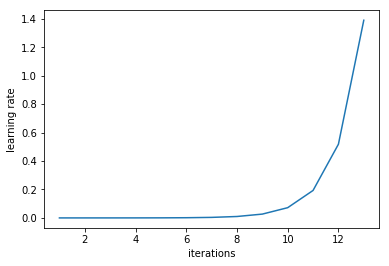

In [8]:
learn.sched.plot_lr()

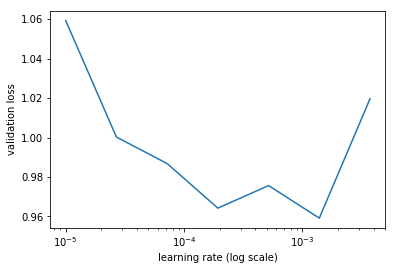

In [9]:
learn.sched.plot(n_skip=0)

In [51]:
learn.unfreeze()

In [52]:
learn.fit(0.00001, 10)

epoch      trn_loss   val_loss   accuracy                  
    0      0.751785   0.725645   0.50463   
    1      0.820576   0.723541   0.50463                   
    2      0.842563   0.730376   0.527778                  
    3      0.812937   0.727245   0.513889                  
    4      0.821215   0.720579   0.527778                  
    5      0.80747    0.716805   0.509259                 
    6      0.818043   0.724713   0.518519                 
    7      0.827199   0.724693   0.523148                 
    8      0.834197   0.724571   0.523148                  
    9      0.835652   0.719558   0.50463                   



[array([0.71956]), 0.5046296307334194]

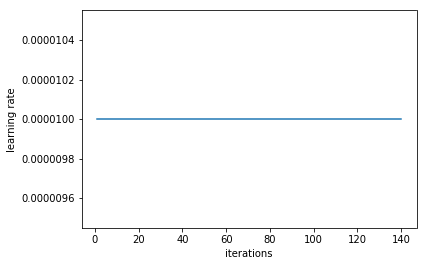

In [48]:
learn.sched.plot_lr()

In [53]:
lr=np.array([1e-5,1e-4,1e-3])

In [54]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                 
    0      0.846941   0.719773   0.523148  
    1      0.837761   0.726581   0.513889                  
    2      0.835667   0.724212   0.550926                  
    3      0.804872   0.721447   0.527778                 
    4      0.796383   0.721047   0.518519                 
    5      0.797486   0.71221    0.50463                   
    6      0.772634   0.719431   0.50463                   



[array([0.71943]), 0.5046296285258399]

In [29]:
data.classes

['dems', 'reps']

In [30]:
log_preds = learn.predict()
log_preds.shape

(216, 2)

In [31]:
log_preds[:10]

array([[-0.21435, -1.6454 ],
       [-0.80694, -0.59099],
       [-0.90591, -0.5178 ],
       [-0.75315, -0.63655],
       [-1.70816, -0.19991],
       [-0.08186, -2.54342],
       [-0.78568, -0.60846],
       [-0.74345, -0.64526],
       [-0.60992, -0.78394],
       [-0.7776 , -0.61528]], dtype=float32)

In [32]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(democrat)

In [34]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


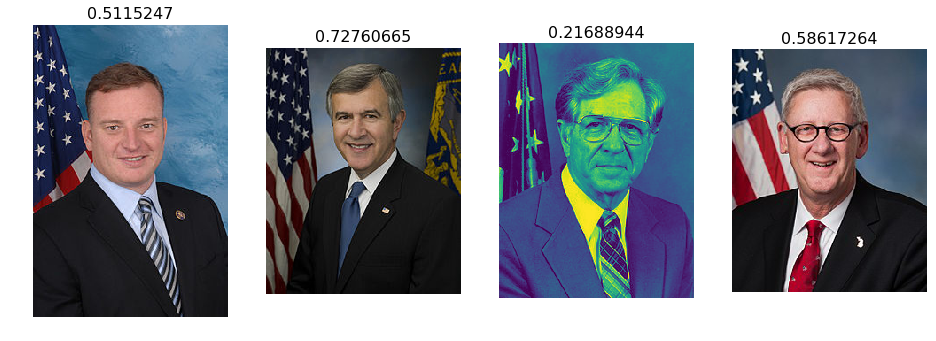

In [35]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [53]:
lr=np.array([1e-1,1e-1,1e-1])

In [54]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

  0%|          | 0/30 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58